In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_style('ticks')

from jwst import datamodels

import corner

import utils

import juliet
import transitspectroscopy as ts

In [2]:
datafolder = 'data/'

# A first, quick-look at the data

There are many data products for JWST and that can be confusing. Here we will focus on two main products:

- The `*uncal.fits` products (really, the uncalibrated products; think of "raw" data).
- The `*rateints.fits` products (think, the "detector, linearity-corrected data").

Let's first read one segment of the uncalibrated products:

In [3]:
tso_uncal1 = datamodels.RampModel(datafolder + 'jw02734002001_04101_00001-seg001_nis_uncal.fits')
tso_uncal2 = datamodels.RampModel(datafolder + 'jw02734002001_04101_00001-seg002_nis_uncal.fits')
tso_uncal3 = datamodels.RampModel(datafolder + 'jw02734002001_04101_00001-seg003_nis_uncal.fits')

In [4]:
print(tso_uncal1.shape)

(100, 14, 256, 2048)


The dimensions of each segment are `(nintegrations, ngroups, nrows, ncolumns)`. Let's put all together in one single array:

In [5]:
# Load uncal data on a single array:
tso_uncal = np.vstack((tso_uncal1.data, tso_uncal2.data))
tso_uncal = np.vstack((tso_uncal, tso_uncal3.data))

In [6]:
tso_uncal.shape

(280, 14, 256, 2048)

Let's plot how a single pixel's ramp looks like on a single integration:

Text(0.5, 0, 'Group number')

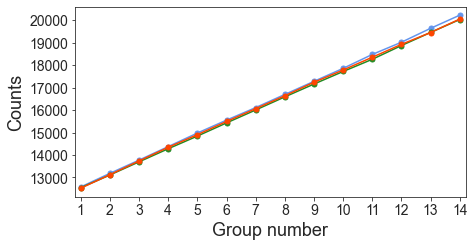

In [7]:
plt.figure(figsize=(7,3.5))

group_index = np.arange(tso_uncal.shape[1]) + 1

plt.plot(group_index, tso_uncal[10, :, 50, 1500], 'o-', color = 'cornflowerblue')
plt.plot(group_index, tso_uncal[11, :, 50, 1500], 'o-', color = 'forestgreen')
plt.plot(group_index, tso_uncal[12, :, 50, 1500], 'o-', color = 'orangered')

plt.xlim(0.8, 14.2)
plt.xticks(range(1,15), fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Counts', fontsize = 18)
plt.xlabel('Group number', fontsize = 18)

Those _appear_ to be nice, linear ramps --- let's check if this is true. Let's fit a line to the first `n=3` groups and remove that from the rest of the ramp:

Text(0.5, 0, 'Group number')

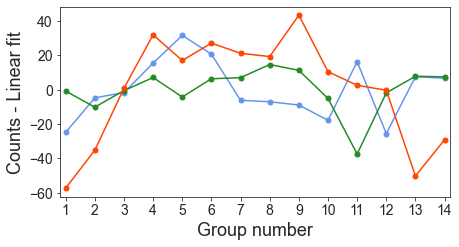

In [8]:
plt.figure(figsize=(7,3.5))

n = 14 # Groups to fit a line to

coeff1 = np.polyfit(group_index[:n], tso_uncal[10, :n, 50, 1500], 1)
val1 = np.polyval(coeff1, group_index)
plt.plot(group_index, tso_uncal[10, :, 50, 1500] - val1, 'o-', color = 'cornflowerblue')

coeff2 = np.polyfit(group_index[:n], tso_uncal[11, :n, 50, 1500], 1)
val2 = np.polyval(coeff2, group_index)
plt.plot(group_index, tso_uncal[11, :, 50, 1500] - val2, 'o-', color = 'forestgreen')

coeff3 = np.polyfit(group_index[:n], tso_uncal[12, :n, 50, 1500], 1)
val3 = np.polyval(coeff3, group_index)
plt.plot(group_index, tso_uncal[12, :, 50, 1500] - val3, 'o-', color = 'orangered')

plt.xlim(0.8, 14.2)
plt.xticks(range(1,15), fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Counts - Linear fit', fontsize = 18)
plt.xlabel('Group number', fontsize = 18)

Let's do the same for _all_ integrations:

(-75.0, 75.0)

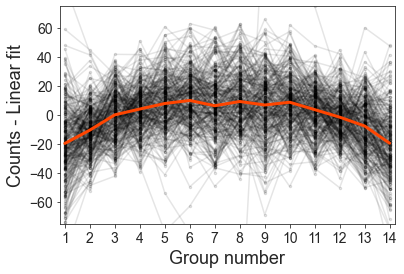

In [9]:
residuals = np.zeros([tso_uncal.shape[0], len(group_index)])

for i in range(tso_uncal.shape[0]):
    
    coeff = np.polyfit(group_index[:n], tso_uncal[i, :n, 50, 1500], 1)
    val = np.polyval(coeff, group_index)
    residuals[i, :] = tso_uncal[i, :, 50, 1500] - val
    plt.plot(group_index, residuals[i, :], '.-', color = 'black', alpha = 0.1)
    
median_residuals = np.nanmedian(residuals, axis = 0)
plt.plot(group_index, median_residuals, color = 'orangered', lw = 3)

plt.xlim(0.8, 14.2)
plt.xticks(range(1,15), fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Counts - Linear fit', fontsize = 18)
plt.xlabel('Group number', fontsize = 18)

plt.ylim(-75, 75)

Very clearly a non-linear ramp! This is the case with every JWST dataset --- they are mostly non-linear throughout a ramp; good news is we know how to correct it.

The JWST pipeline produces the bias-corrected, linearity-corrected, dark-corrected, etc., _ramps/rates_ of those up-the-ramp samples (i.e., the slopes of the "linearized" counts). How the pipeline goes from these uncalibrated ramps to full calibrated ramps, see [this video](https://exoplanet-talks.org/talk/365) (slides [here](https://ers-transit.github.io/talks/hackathon/ers-hackathon-day1-espinoza-what-to-expect.pdf)). 

These calibrated data are accessible directly from the *rateints.fits files below:

In [10]:
# Load data using datamodels:
tso1 = datamodels.open(datafolder + 'jw02734002001_04101_00001-seg001_nis_rateints.fits')
tso2 = datamodels.open(datafolder + 'jw02734002001_04101_00001-seg002_nis_rateints.fits')
tso3 = datamodels.open(datafolder + 'jw02734002001_04101_00001-seg003_nis_rateints.fits')

In [11]:
tso1.search('date')

root (AsdfObject)
└─meta (dict)
  ├─date (str): 2023-07-08T21:59:23.325
  └─observation (dict)
    ├─date (str): 2022-06-21
    ├─date_beg (str): 2022-06-21T04:06:23.898
    └─date_end (str): 2022-06-21T10:30:58.698

In [12]:
# Load data on a single array:
tso = np.vstack((tso1.data, tso2.data))
tso = np.vstack((tso, tso3.data))

# Errors:
tso_err = np.vstack((tso1.err, tso2.err))
tso_err = np.vstack((tso_err, tso3.err))

# Data-quality flags:
tso_dq = np.vstack((tso1.dq, tso2.dq))
tso_dq = np.vstack((tso_dq, tso3.dq))

In [13]:
# Generate the median frame:
median_tso = np.median(tso, axis = 0) 

In [14]:
# Correcting for NaN in the data
median_tso = utils.replace_nan(median_tso)
for i in range(tso.shape[0]):
    tso[i,:,:] = utils.replace_nan(tso[i,:,:])

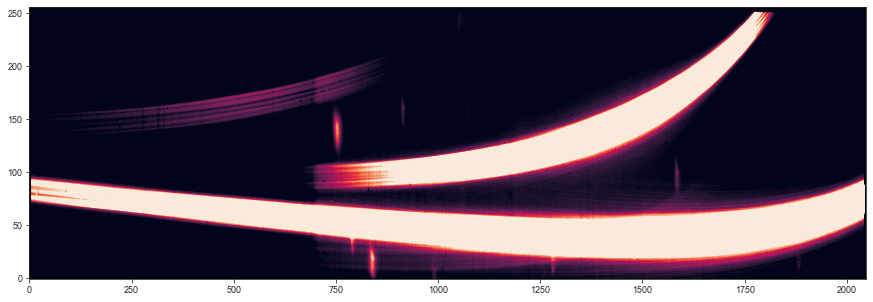

In [15]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')
im.set_clim(4,10)

Is the transit there?

In [16]:
postage = tso[:, 20:60, 1500:1550]

In [17]:
timeseries = np.sum(postage, axis = (1,2))

Text(0.5, 0, 'Integration number')

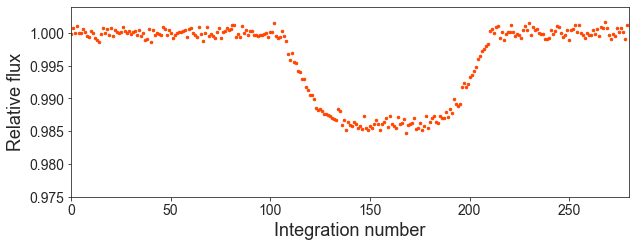

In [18]:
plt.figure(figsize=(10,3.5))

plt.plot(timeseries / np.median(timeseries[0:80]), '.', color = 'orangered')

plt.ylim(0.975,1.004)
plt.xlim(0, len(timeseries))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Relative flux', fontsize = 18)
plt.xlabel('Integration number', fontsize = 18)

In [19]:
# Create smoothed version to use for background + 1/f corrections:
smoothed_petit_transit = median_filter(timeseries / np.median(timeseries[0:80]), 11)

Text(0.5, 0, 'Integration number')

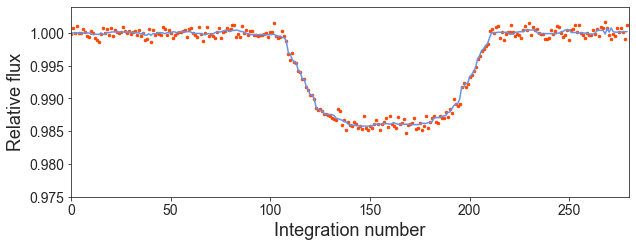

In [20]:
plt.figure(figsize=(10,3.5))

plt.plot(timeseries / np.median(timeseries[0:80]), '.', color = 'orangered')
plt.plot(smoothed_petit_transit, '-', color = 'cornflowerblue')

plt.ylim(0.975,1.004)
plt.xlim(0, len(timeseries))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Relative flux', fontsize = 18)
plt.xlabel('Integration number', fontsize = 18)

Phew! Nice-centered transit. Let's jump to spectral tracing & extraction now

## 1. Tracing & Extraction

### 1.1 Spectral tracing

Let's go to spectral tracing first. To this end, we define some CCF parameters to define the double-gaussian we will cross-correlate against the data:

In [21]:
ccf_parameters = [-7.5, 3.0, 7.5, 3.0]

In [22]:
lags1, ccf1 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 2043], 
                                         function = 'double gaussian', parameters = ccf_parameters)
lags2, ccf2 = ts.spectroscopy.get_ccf(np.arange(median_tso.shape[0]), median_tso[:, 1750], 
                                         function = 'double gaussian', parameters = ccf_parameters)

75.09100000000001


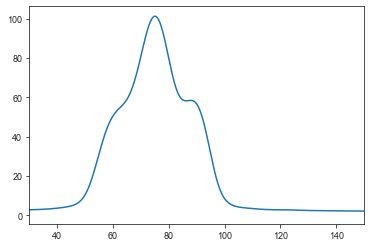

In [23]:
plt.plot(lags1, ccf1)
plt.xlim(30,150)

idx = np.where(np.max(ccf1) == ccf1)[0]
ystart1 = lags1[idx][0]
print(ystart1)

227.88400000000001


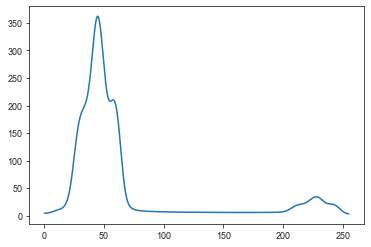

In [24]:
plt.plot(lags2, ccf2)

idx_large = np.where(lags2>200)[0]
ccf2 = np.array(ccf2)

idx = np.where( np.max(ccf2[idx_large]) == ccf2[idx_large] )[0]

ystart2 = lags2[idx_large][idx][0]
print(ystart2)

In [25]:
x1, y1 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                           xstart = 2043, ystart = ystart1, xend = 4, 
                                           ccf_function = 'double gaussian', 
                                           ccf_parameters = ccf_parameters)

Now Order 2:

In [26]:
x2_end, x2_start = 600, 1750

x2, y2 = ts.spectroscopy.trace_spectrum(median_tso, np.zeros(median_tso.shape), 
                                           xstart = x2_start, ystart = ystart2, xend = x2_end, 
                                           ccf_function = 'double gaussian', 
                                           ccf_parameters = ccf_parameters, 
                                           y_tolerance = 4)

Let's see how we did:

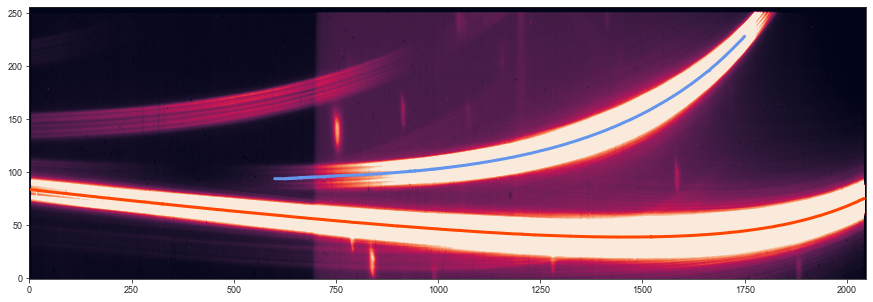

In [27]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

plt.plot(x1, y1, color = 'orangered', lw = 3)
plt.plot(x2, y2, color = 'cornflowerblue', lw = 3)

im.set_clim(2,10)

Not very nice. Problem is the trace goes off after column about 1250

In [28]:
x_knots1 = [[6, 1200-5], [1200, 1500-5], [1500, 1700-5],[1700, 2041]]
nknots1 = [4,2,3,4]

x_knots2 = [[601, 850-5], [850, 1100-5],[1100,1749]]
nknots2 = [2, 2, 5]

In [29]:
_, sfit1 = ts.utils.fit_spline(x1, y1, nknots = nknots1, x_knots = x_knots1)
_, sfit2 = ts.utils.fit_spline(x2, y2, nknots = nknots2, x_knots = x_knots2)

Let's check these fits:

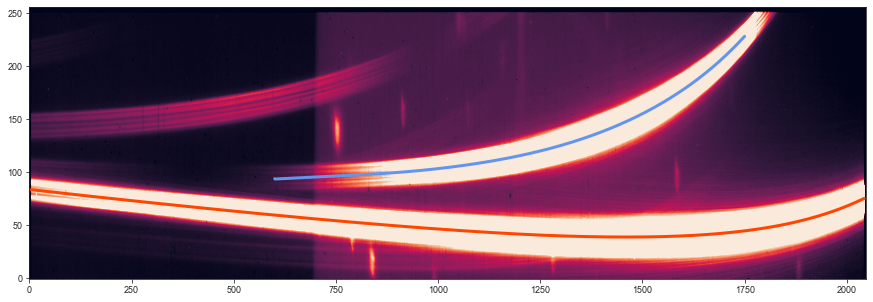

In [30]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')

plt.plot(x1, sfit1, color = 'orangered', lw = 3)
plt.plot(x2, sfit2, color = 'cornflowerblue', lw = 3)

im.set_clim(2,10)

Nice and smooth! Let's define those as the y's:

In [31]:
y1, y2 = sfit1, sfit2

Let's get the times:

In [32]:
times = np.append(tso1.int_times['int_mid_BJD_TDB'], tso2.int_times['int_mid_BJD_TDB'])
times = np.append(times, tso3.int_times['int_mid_BJD_TDB'])

In [33]:
times.shape

(280,)

## 2. 1/f and sky/zodii background substraction

Let's correct for the zodiacal background first:

In [34]:
model_bkg = np.load('model_background256.npy')

Is the same region as the other still working?

(200.0, 256.0)

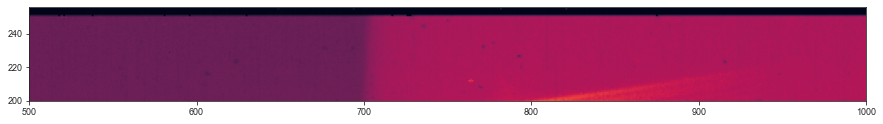

In [35]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower')
im.set_clim(0,8)
plt.xlim(500,1000)
plt.ylim(200,256)

That works! Let's scale:

In [36]:
bkg_postage = median_tso[210:250,500:800]
model_bkg_postage = model_bkg[210:250,500:800]

ratio = bkg_postage / model_bkg_postage
ratio = ratio.flatten()

idx_sorted = np.argsort(ratio)
npixels = len(ratio)

Let's see how the background distribution looks like:

In [37]:
lower_percentile, upper_percentile = 0.25, 0.5

Text(0.5, 0, 'Pixel index')

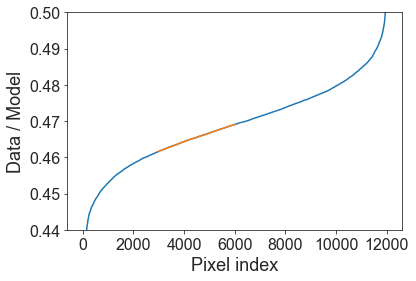

In [38]:
pixel_index = np.arange(len(ratio))
plt.plot(pixel_index, ratio[idx_sorted])
idx_lower = int(npixels*lower_percentile)
idx_upper = int(npixels*upper_percentile)
plt.plot(pixel_index[idx_lower:idx_upper], ratio[idx_sorted][idx_lower:idx_upper])
plt.ylim(0.44,0.5)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Data / Model', fontsize = 18)
plt.xlabel('Pixel index', fontsize = 18)

Text(0.5, 0, 'Pixel index')

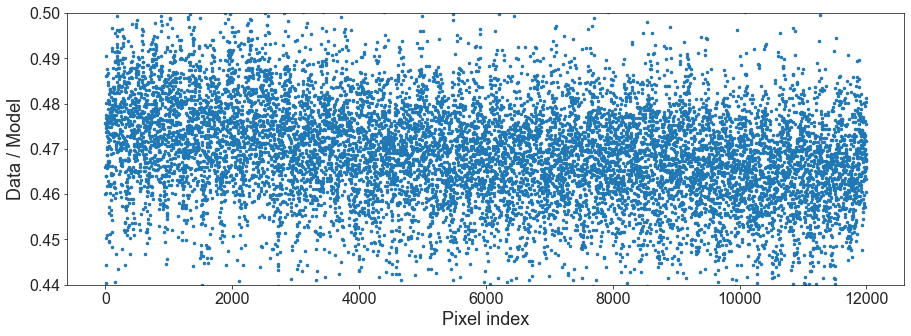

In [39]:
plt.figure(figsize=(15,5))
plt.plot(ratio, '.')
plt.ylim(0.44,0.5)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Data / Model', fontsize = 18)
plt.xlabel('Pixel index', fontsize = 18)

0.46551958427499807


Text(0.5, 0, 'Pixel index')

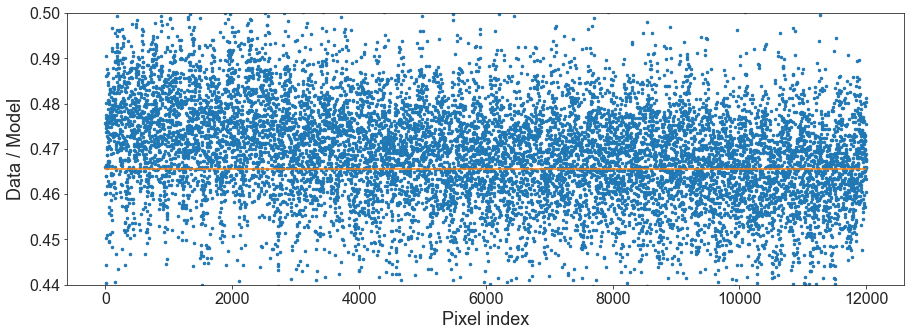

In [40]:
median_ratio = np.median(ratio[idx_sorted][idx_lower:idx_upper])
print(median_ratio)

plt.figure(figsize=(15,5))
plt.plot(ratio, '.')
plt.plot([0, len(ratio)], [median_ratio, median_ratio])
plt.ylim(0.44,0.5)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Data / Model', fontsize = 18)
plt.xlabel('Pixel index', fontsize = 18)

In [41]:
original_pixels = bkg_postage.flatten()
bkg_substracted_pixels = bkg_postage.flatten() - model_bkg_postage.flatten() * median_ratio

In [42]:
print(np.median(bkg_substracted_pixels))
print(np.median(original_pixels))

0.018861883585569617
2.2252102


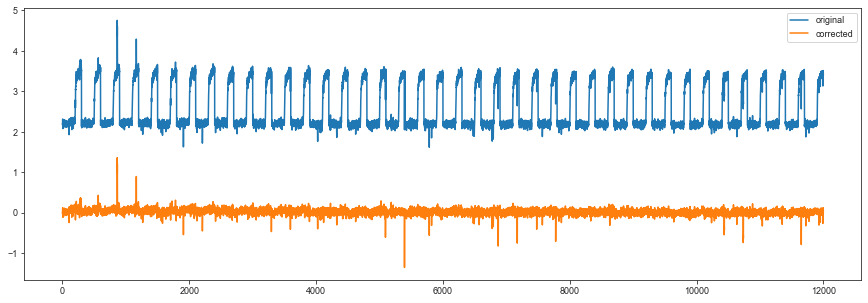

In [43]:
non_outliers_original = np.where( (bkg_postage.flatten() < 10.5)&(bkg_postage.flatten() > 1.0))[0]

plt.figure(figsize=(15,5))

plt.plot(original_pixels[non_outliers_original], label = 'original')
plt.plot(bkg_substracted_pixels[non_outliers_original], label = 'corrected')
plt.legend()

Cool! Let's apply that ratio we found to the data. First to the median:

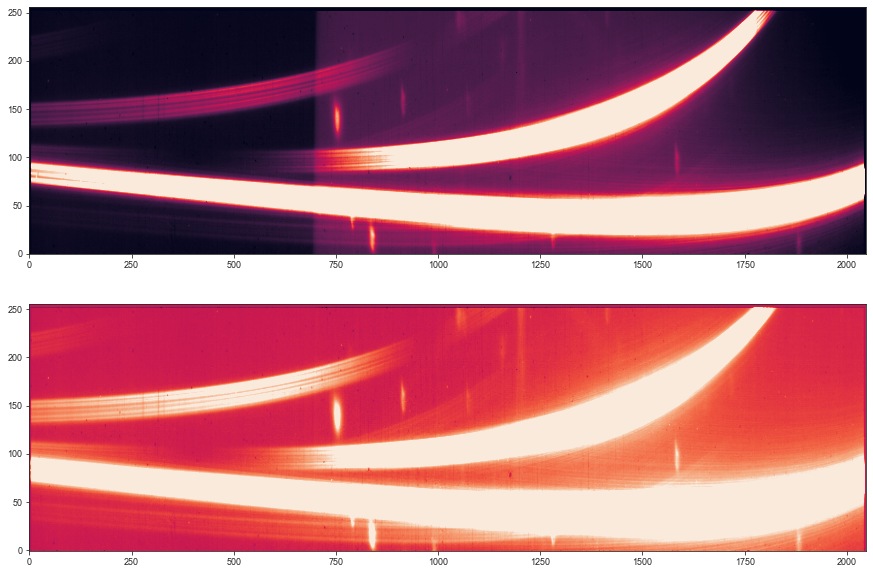

In [44]:
plt.figure(figsize=(15,10))

plt.subplot(211)
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')
im.set_clim(2,10)

plt.subplot(212)
im = plt.imshow(median_tso - model_bkg * median_ratio, origin = 'lower', aspect = 'auto')
im.set_clim(-3,3)


Nice! Now, let's explore the level or 1/f noise in a background corrected integration:

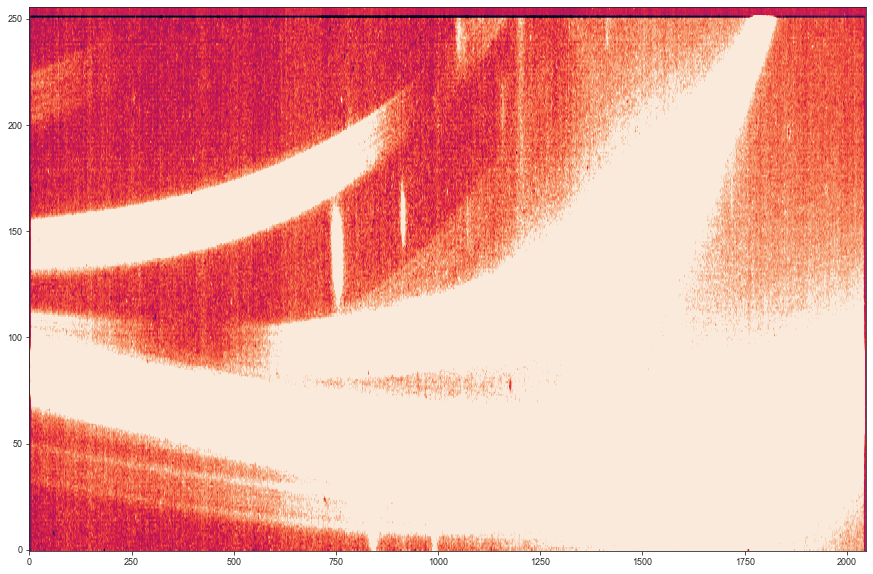

In [45]:
plt.figure(figsize=(15,10))

bkg_corrected_frame = tso[0, :, :] - model_bkg * median_ratio

im = plt.imshow(bkg_corrected_frame, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)

Note the "banding"? That's 1/f noise. Now, this is not easy to remove in SOSS. 

In theory, if we had "background pixels" it would be easy to remove _part_ of the problem on a column-to-column basis, but these regions are hard to find because almost the entire SOSS frame is filled with flux. 

There's a trick I discovered, however. Assuming the noise from each frame is independant, the median frame should have a _much_ reduced 1/f noise level. Also, removing the median frame from each _individual_ frame should give me back basically the detector noise only. Let's get the out-of-transit median frame:

In [46]:
# Replace here integrations before and after transit:
int_before_transit = 100
int_after_transit = 220

bkg_corrected_oot_integrations = np.vstack((tso[:int_before_transit, :, :] - model_bkg * median_ratio, \
                              tso[int_after_transit:, :, :] - model_bkg * median_ratio))

bkg_corrected_median_oot = np.nanmedian(bkg_corrected_oot_integrations, axis = 0 )

Now let's subtract this to the individual frame we showed above:

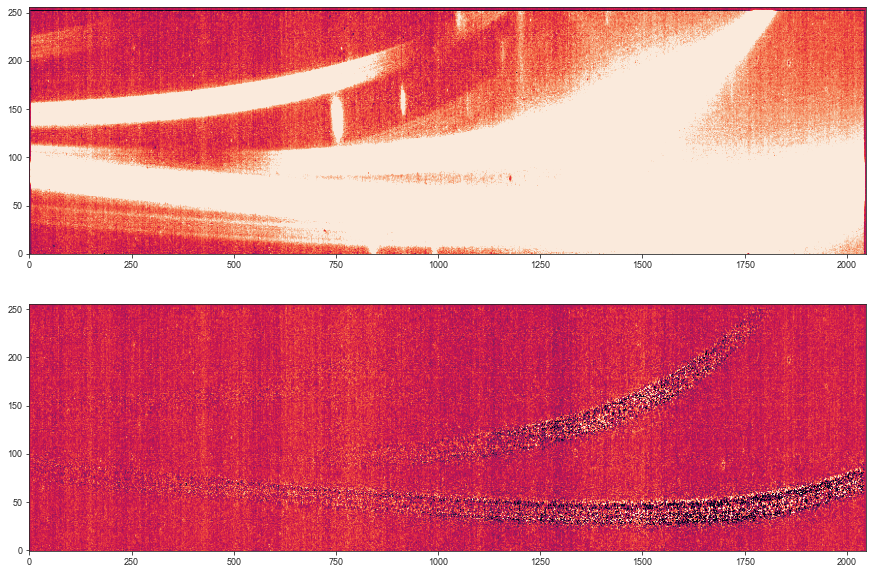

In [47]:
plt.figure(figsize=(15,10))

plt.subplot(211)
im = plt.imshow(bkg_corrected_frame, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)

plt.subplot(212)
im = plt.imshow(bkg_corrected_frame - bkg_corrected_median_oot, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)

See how this allows us to "see" the banding much more clearly? This leaves us basically only with detector-level effects. We can use this frame to correct our original frame. We write a function that does exactly this following pixels close to the trace. Let's check the technique out:

In [48]:
def correct_1f(median_frame, frame, x, y, min_bkg = 20, max_bkg = 35, mask = None, scale_factor = 1., return_1f = False):
    """
    This. Needs. A. zodii-bkg-corrected. Frame as input :).
    """
    
    new_frame = np.copy(frame)
    
    ms = frame - median_frame * scale_factor
    
    if return_1f:
        
        one_over_f = np.zeros(len(x))
    
    # Go column-by-column substracting values around the trace:
    for i in range(len(x)):
        
        column = x[i]
        row = int(y[i])
        
        min_row = np.max([0, row - 35])
        max_row = np.min([256, row + 35])
        
        bkg = np.append(ms[min_row:row-20, column], ms[row+20:max_row, column])
        new_frame[:, column] = new_frame[:, column] - np.nanmedian(bkg)
        
        if return_1f:
            
            one_over_f[i] = np.nanmedian(bkg)
        
    if return_1f:
        
        return one_over_f, new_frame
        
    else:
        
        return new_frame

Let's try it:

In [49]:
one_over_f, new_frame = correct_1f(bkg_corrected_median_oot, \
                                   tso[0, :, :]  - model_bkg * median_ratio, \
                                   x1, y1, \
                                   scale_factor = smoothed_petit_transit[0], \
                                   return_1f = True)

Text(0.5, 0, 'Pixel (wavelength direction)')

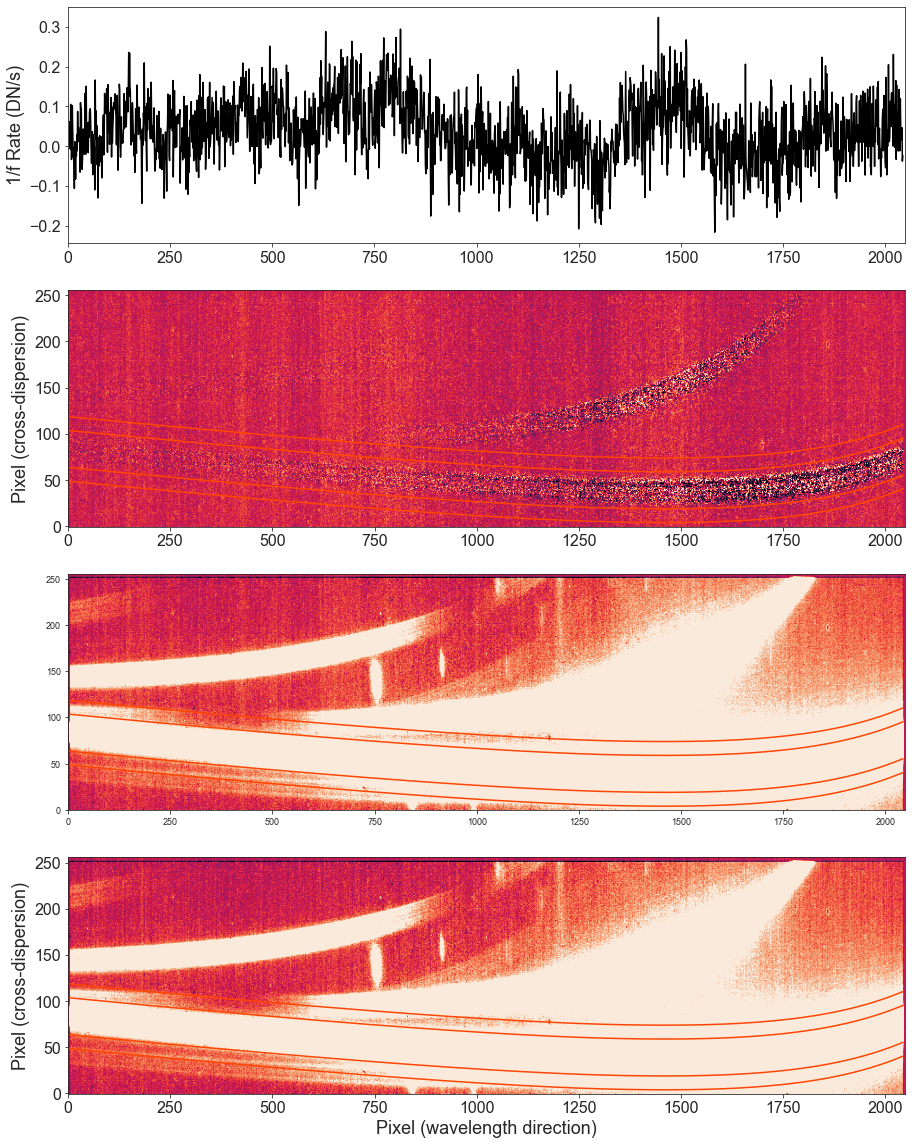

In [50]:
plt.figure(figsize=(15,20))

plt.subplot(411)
plt.plot(x1, one_over_f, color = 'black')
im.set_clim(-5,5)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('1/f Rate (DN/s)', fontsize = 18)
plt.xlim(0, 2048)

plt.subplot(412)
plt.plot(x1, y1 + 35, color = 'orangered')
plt.plot(x1, y1 + 20, color = 'orangered')
plt.plot(x1, y1 - 20, color = 'orangered')
plt.plot(x1, y1 - 35, color = 'orangered')
im = plt.imshow(bkg_corrected_frame - bkg_corrected_median_oot, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Pixel (cross-dispersion)', fontsize = 18)

plt.subplot(413)
plt.plot(x1, y1 + 35, color = 'orangered')
plt.plot(x1, y1 + 20, color = 'orangered')
plt.plot(x1, y1 - 20, color = 'orangered')
plt.plot(x1, y1 - 35, color = 'orangered')
im = plt.imshow(bkg_corrected_frame, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)

plt.subplot(414)
plt.plot(x1, y1 + 35, color = 'orangered')
plt.plot(x1, y1 + 20, color = 'orangered')
plt.plot(x1, y1 - 20, color = 'orangered')
plt.plot(x1, y1 - 35, color = 'orangered')
im = plt.imshow(new_frame, origin = 'lower', aspect = 'auto')
im.set_clim(-1,1)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Pixel (cross-dispersion)', fontsize = 18)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Pixel (cross-dispersion)', fontsize = 18)
plt.xlabel('Pixel (wavelength direction)', fontsize = 18)

Let's apply this same thing to every spectrum:

In [51]:
spectra1_15 = np.zeros([tso.data.shape[0], len(x1)])
spectra1_15_err = np.zeros([tso.data.shape[0], len(x1)])

spectra2_15 = np.zeros([tso.data.shape[0], len(x2)])
spectra2_15_err = np.zeros([tso.data.shape[0], len(x2)])

for i in range(tso.shape[0]):
    
    bkg_subs_frame = correct_1f(bkg_corrected_median_oot, \
                                tso[i, :, :]  - model_bkg * median_ratio, \
                                x1, y1, \
                                scale_factor = smoothed_petit_transit[i])
    
    spectra1_15[i, :], spectra1_15_err[i, :] = ts.spectroscopy.getSimpleSpectrum(bkg_subs_frame, 
                                                                                 x1,
                                                                                 y1, 
                                                                                 15, 
                                                                                 error_data=tso_err[i, :, :], 
                                                                                 correct_bkg=False)  

    bkg_subs_frame = correct_1f(bkg_corrected_median_oot, \
                                tso[i, :, :]  - model_bkg * median_ratio, \
                                x2, y2, \
                                scale_factor = smoothed_petit_transit[i])
    
    spectra2_15[i, :], spectra2_15_err[i, :] = ts.spectroscopy.getSimpleSpectrum(bkg_subs_frame, 
                                                                                 x2,
                                                                                 y2, 
                                                                                 15, 
                                                                                 error_data=tso_err[i, :, :], 
                                                                                 correct_bkg=False)  

Plot the extracted spectra:

Text(0, 0.5, 'DN /s ')

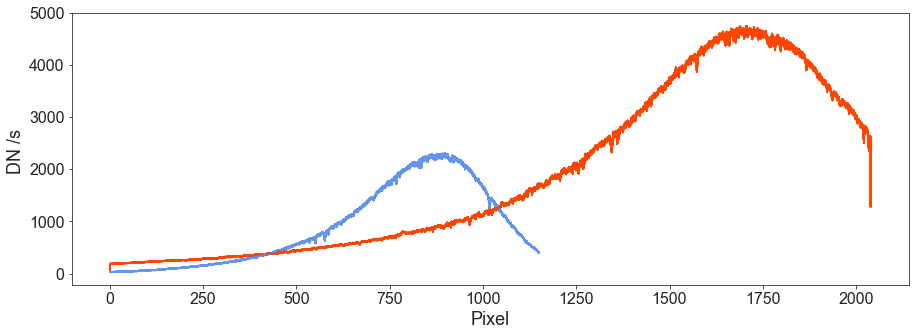

In [52]:
plt.figure(figsize=(15,5))

for i in range(spectra1_15.shape[0]):
    
    plt.plot(spectra1_15[i,:], color = 'orangered', alpha = 0.1)
    plt.plot(spectra2_15[i,:], color = 'cornflowerblue', alpha = 0.1)
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

Close-up to see the transit:

Text(0, 0.5, 'DN /s ')

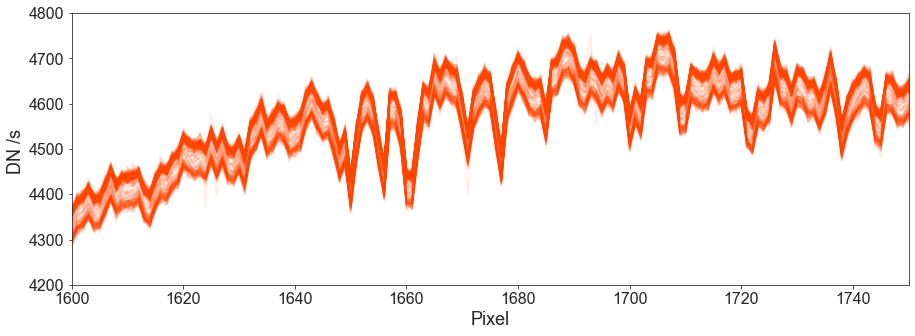

In [53]:
plt.figure(figsize=(15,5))

for i in range(spectra1_15.shape[0]):
    
    plt.plot(spectra1_15[i,:], color = 'orangered', alpha = 0.1)
    plt.plot(spectra2_15[i,:], color = 'cornflowerblue', alpha = 0.1)
    
plt.xlim(1600,1750)
plt.ylim(4200,4800)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

Nice. Let's form a master scaled spectrum that then we'll scale back to each integration to correct bad columns:

In [54]:
master_spectra1 = np.zeros(spectra1_15.shape)
master_spectra2 = np.zeros(spectra2_15.shape)

for i in range(spectra1_15.shape[0]):
    
    master_spectra1[i, :] = spectra1_15[i,:] / np.nanmedian(spectra1_15[i,:])
    master_spectra2[i, :] = spectra2_15[i,:] / np.nanmedian(spectra2_15[i,:])

Text(0, 0.5, 'DN /s ')

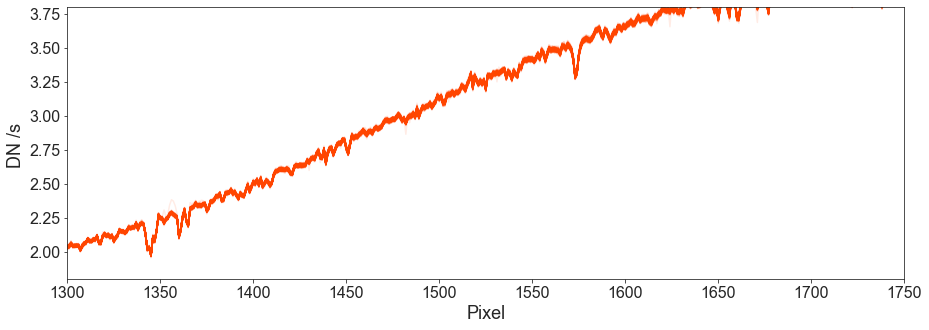

In [55]:
plt.figure(figsize=(15,5))

for i in range(spectra1_15.shape[0]):
    
    plt.plot(master_spectra1[i,:], color = 'orangered', alpha = 0.1)
    plt.plot(master_spectra2[i,:], color = 'cornflowerblue', alpha = 0.1)
    
plt.xlim(1300,1750)
plt.ylim(1.8,3.8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

Get median spectrum and error at each pixel so we can scale:

In [56]:
master_spectrum1 = np.zeros(spectra1_15.shape[1])
sigma_master_spectrum1 = np.zeros(spectra1_15.shape[1])
master_spectrum2 = np.zeros(spectra2_15.shape[1])
sigma_master_spectrum2 = np.zeros(spectra2_15.shape[1])

for i in range(spectra1_15.shape[1]):
    
    median1 = np.nanmedian(master_spectra1[:, i])
    master_spectrum1[i], sigma_master_spectrum1[i] = median1, \
                                                     1.2533*ts.utils.get_mad_sigma(median1, master_spectra1[:, i])

for i in range(spectra2_15.shape[1]):
    median2 = np.nanmedian(master_spectra2[:, i])
    master_spectrum2[i], sigma_master_spectrum2[i] = median2, \
                                                     1.2533*ts.utils.get_mad_sigma(median2, master_spectra2[:, i])

Check that errors make sense:

Text(0, 0.5, 'DN /s ')

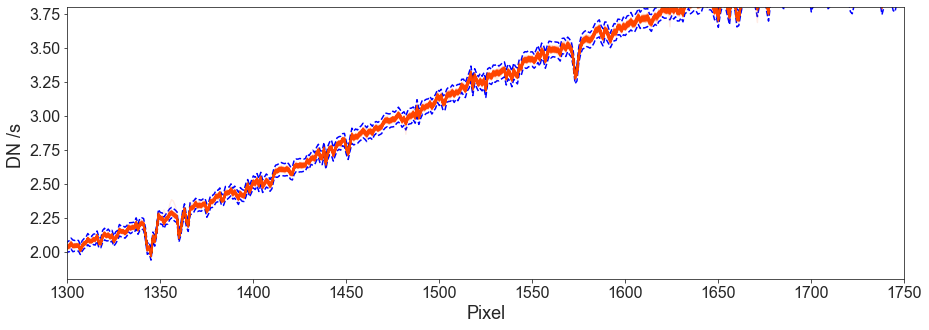

In [57]:
plt.figure(figsize=(15,5))

plt.plot(master_spectrum1 - 5*sigma_master_spectrum1, 'b--')
plt.plot(master_spectrum1 + 5*sigma_master_spectrum1, 'b--')

for i in range(spectra1_15.shape[0]):
    
    plt.plot(master_spectra1[i,:], color = 'orangered', alpha = 0.1)
    plt.plot(master_spectra2[i,:], color = 'cornflowerblue', alpha = 0.1)
    
plt.xlim(1300,1750)
plt.ylim(1.8,3.8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

Awesome! Now, go through all integrations, scale the median spectrum and replace any 5-sigma outliers. Let's first test it on an example integration:

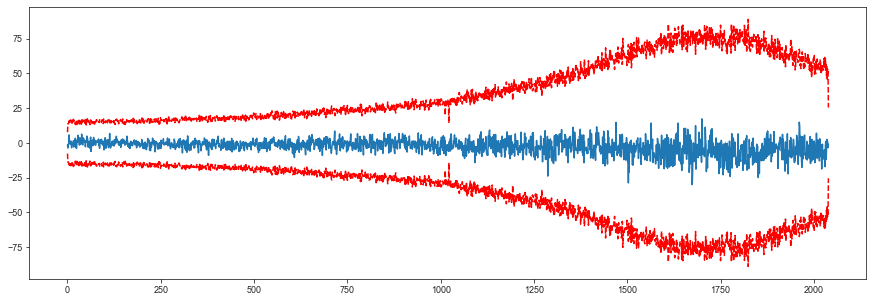

In [58]:
integration = 70

# Get median to scale:
median = np.median(spectra1_15[integration, :])

# Scale master spectrum and sigma:
model = master_spectrum1 * median
sigma = sigma_master_spectrum1 * median

# Plot both:
plt.figure(figsize=(15,5))

plt.plot(spectra1_15[integration, :] - model)
plt.plot(5*sigma, 'r--')
plt.plot(-5*sigma, 'r--')

Works nicely! Let's apply this:

In [59]:
corrected_spectra1 = np.copy(spectra1_15)
corrected_spectra2 = np.copy(spectra2_15)

corrected_spectra1_err = np.copy(spectra1_15_err)
corrected_spectra2_err = np.copy(spectra2_15_err)

for i in range(spectra1_15.shape[0]):
    
    # First Order 1. Get median to scale:
    median = np.median(spectra1_15[i, :])

    # Scale master spectrum and sigma:
    model = master_spectrum1 * median
    sigma = sigma_master_spectrum1 * median
    
    # Identify bad pixels/columns:
    residuals = np.abs(spectra1_15[i, :] - model)
    idx_bad = np.where(residuals > 5 * sigma)[0]
    
    # Replace:
    if len(idx_bad) != 0:
        
        corrected_spectra1[i, idx_bad] = model[idx_bad]
        corrected_spectra1_err[i, idx_bad] = sigma[idx_bad]
        
    # Repeat for Order 2:
    median = np.median(spectra2_15[i, :])

    # Scale master spectrum and sigma:
    model = master_spectrum2 * median
    sigma = sigma_master_spectrum2 * median
    
    # Identify bad pixels/columns:
    residuals = np.abs(spectra2_15[i, :] - model)
    idx_bad = np.where(residuals > 5 * sigma)[0]
    
    # Replace:
    if len(idx_bad) != 0:
        
        corrected_spectra2[i, idx_bad] = model[idx_bad]
        corrected_spectra2_err[i, idx_bad] = sigma[idx_bad]

Let's see how it looks like:

Text(0, 0.5, 'DN /s ')

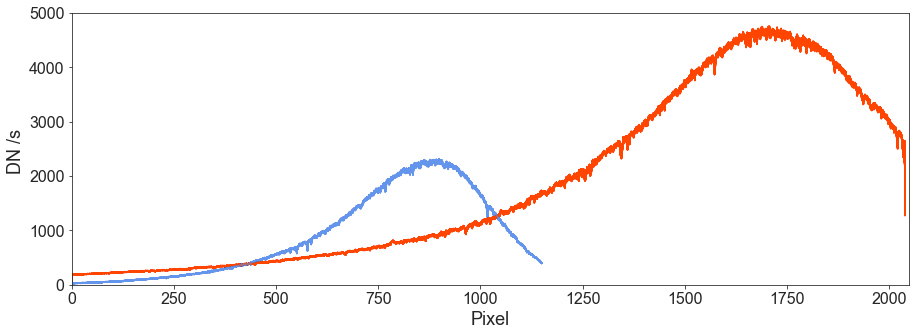

In [60]:
plt.figure(figsize=(15,5))

for i in range(spectra1_15.shape[0]):
    
    plt.plot(corrected_spectra1[i,:], color = 'orangered', alpha = 0.1)
    plt.plot(corrected_spectra2[i,:], color = 'cornflowerblue', alpha = 0.1)
    
plt.xlim(0, 2048)
plt.ylim(0, 5000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

That looks great! Let's package them up (and save results):

In [61]:
wavelength_solution1 = np.loadtxt('order1_wavelength_solution.txt', unpack=True)
wavelength_solution2 = np.loadtxt('order2_wavelength_solution.txt', unpack=True)
wavelength_solution3 = np.loadtxt('order3_wavelength_solution.txt', unpack=True)

spectra = {}
spectra['order1'] = {}
spectra['order2'] = {}
spectra['order1']['wavelength'] = wavelength_solution1[4:2044]
spectra['order2']['wavelength'] = wavelength_solution2[x2_end:x2_start+1][600:]

spectra['order1']['spectra'] = []
spectra['order2']['spectra'] = []
spectra['order1']['errors'] = []
spectra['order2']['errors'] = []

for i in range(tso.shape[0]):

    spectra['order1']['spectra'].append(corrected_spectra1[i, :])
    spectra['order2']['spectra'].append(corrected_spectra2[i, 600:])
    spectra['order1']['errors'].append(corrected_spectra1_err[i, :])
    spectra['order2']['errors'].append(corrected_spectra2_err[i, 600:])

In [62]:
import os

if not os.path.exists('stellar_spectra.pkl'):
    
    filehandler = open("stellar_spectra.pkl","wb")
    pickle.dump(spectra ,filehandler)
    filehandler.close()

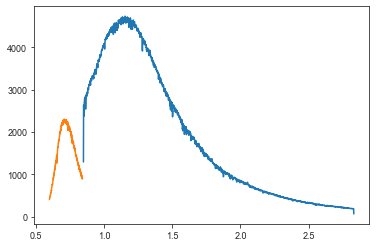

In [63]:
plt.plot(spectra['order1']['wavelength'], spectra['order1']['spectra'][0])

plt.plot(spectra['order2']['wavelength'], spectra['order2']['spectra'][0])

## 3. Lightcurve packaging and fitting

Let's pack the wavelength dependant lightcurves:

In [64]:
# Generate lightcurves:
lcs={}

In [65]:
regenerate_order1 = True

if regenerate_order1:

    order = 'order1'
    get_white_light = True
    lcs[order] = {}

    # This if true below is just because im lazy and dont want to take tabs back
    if True:

            if get_white_light:

                # Get white-light lightcurve first:
                lcs[order+' white light'] = {}
                lc = np.array([])
                lcerr = np.array([])

                for i in range(len(spectra[order]['spectra'])):
                    lc = np.append(lc, np.sum(spectra[order]['spectra'][i]))
                    lcerr = np.append(lcerr, np.sqrt(np.sum(spectra[order]['errors'][i]**2)))

                lcs[order+' white light']['flux'] = np.copy(lc)
                lcs[order+' white light']['errors'] = np.copy(lcerr)

            # Start saving from the smallest wavelength and up:
            idx_non_zero = np.where( (spectra[order]['wavelength'] != 0.0) & ~(np.isnan(spectra[order]['wavelength']))  )[0]
            current_wavelength = np.min(spectra[order]['wavelength'][idx_non_zero])

            while True:

                idx = np.where(spectra[order]['wavelength'] == current_wavelength)[0]
                lc = np.array([])
                lcerr = np.array([])

                for i in range(len(spectra[order]['spectra'])):

                    lc = np.append(lc, spectra[order]['spectra'][i][idx])
                    lcerr = np.append(lcerr, spectra[order]['errors'][i][idx])

                lcs[order][current_wavelength] = {}
                lcs[order][current_wavelength]['flux'] = np.copy(lc)
                lcs[order][current_wavelength]['errors'] = np.copy(lcerr)

                # Go to the next wavelengths:
                idx_next = np.where((spectra[order]['wavelength'] != current_wavelength) & (spectra[order]['wavelength'] > current_wavelength))[0]

                if len(idx_next) == 0:
                    break
                else:
                    current_wavelength = np.min(spectra[order]['wavelength'][idx_next])

In [66]:
regenerate_order2 = True

if regenerate_order2:

    order = 'order2'
    get_white_light = True
    lcs[order] = {}

    # This if true below is just because im lazy and dont want to take tabs back
    if True:

            if get_white_light:

                # Get white-light lightcurve first:
                lcs[order+' white light'] = {}
                lc = np.array([])
                lcerr = np.array([])

                for i in range(len(spectra[order]['spectra'])):
                    lc = np.append(lc, np.sum(spectra[order]['spectra'][i]))
                    lcerr = np.append(lcerr, np.sqrt(np.sum(spectra[order]['errors'][i]**2)))

                lcs[order+' white light']['flux'] = np.copy(lc)
                lcs[order+' white light']['errors'] = np.copy(lcerr)

            # Start saving from the smallest wavelength and up:
            idx_non_zero = np.where( (spectra[order]['wavelength'] != 0.0) & ~(np.isnan(spectra[order]['wavelength']))  )[0]
            current_wavelength = np.min(spectra[order]['wavelength'][idx_non_zero])

            while True:

                idx = np.where(spectra[order]['wavelength'] == current_wavelength)[0]
                lc = np.array([])
                lcerr = np.array([])

                for i in range(len(spectra[order]['spectra'])):

                    lc = np.append(lc, spectra[order]['spectra'][i][idx])
                    lcerr = np.append(lcerr, spectra[order]['errors'][i][idx])

                lcs[order][current_wavelength] = {}
                lcs[order][current_wavelength]['flux'] = np.copy(lc)
                lcs[order][current_wavelength]['errors'] = np.copy(lcerr)

                # Go to the next wavelengths:
                idx_next = np.where((spectra[order]['wavelength'] != current_wavelength) & (spectra[order]['wavelength'] > current_wavelength))[0]

                if len(idx_next) == 0:
                    break
                else:
                    current_wavelength = np.min(spectra[order]['wavelength'][idx_next])

In [67]:
lcs['times'] = times + 2400000.5
t = lcs['times']

In [68]:
if not os.path.exists('lcs.pkl'):
    
    filehandler = open("lcs.pkl","wb")
    pickle.dump(lcs ,filehandler)
    filehandler.close()

### 3.1 Get lightcurve residual maps & lightcurve plots

In [69]:
# Let's iterate then to get all the lightcurves:
matrices = {}
ntimes = len(t)

for order in ['order1', 'order2']:

    # Create the matrix for each order. First, extract wavelengths, and number of wavelengths:
    matrices[order+' wavelengths'] = list(lcs[order].keys())
    nwavs = len(lcs[order].keys())
    print(order, nwavs)

    # Create matrix that will store fluxes:
    matrices[order] = np.zeros([nwavs, ntimes])

    for i in range(nwavs):
        wavelength = matrices[order+' wavelengths'][i]
        norm_lc = lcs[order][wavelength]['flux'] / np.median(lcs[order][wavelength]['flux'])
        matrices[order][i,:] = (norm_lc - 1.)*1e6

order1 2040
order2 551


Little plot to guess a time-of-transit center:

Text(0.5, 0, 'Time from mid-transit (days)')

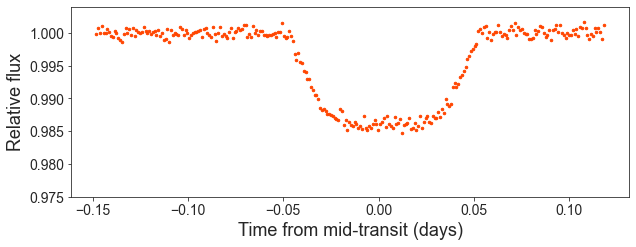

In [70]:
plt.figure(figsize=(10,3.5))

plt.plot(t - np.mean(t+0.015), timeseries / np.median(timeseries[0:80]), '.', color = 'orangered')

plt.ylim(0.975,1.004)
#plt.xlim(0, len(timeseries))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Relative flux', fontsize = 18)
plt.xlabel('Time from mid-transit (days)', fontsize = 18)

In [71]:
# Define period of the exoplanet:
period = 3.4252602
# Time-of-transit center:
transit_center = np.mean(t+0.015)
# Update transit center to this day:
n = np.ceil((t[0] - transit_center) / period)
transit_center = transit_center + n * period
# Planet-to-star radius ratio:
rprs = 0.1186
# Transit duration in days:
transit_duration = 2.4264/24.

In [72]:
phases = juliet.utils.get_phases(t, period, transit_center)
times_hours = phases * period * 24.

from mpl_toolkits.axes_grid1 import make_axes_locatable

<Figure size 1296x252 with 0 Axes>

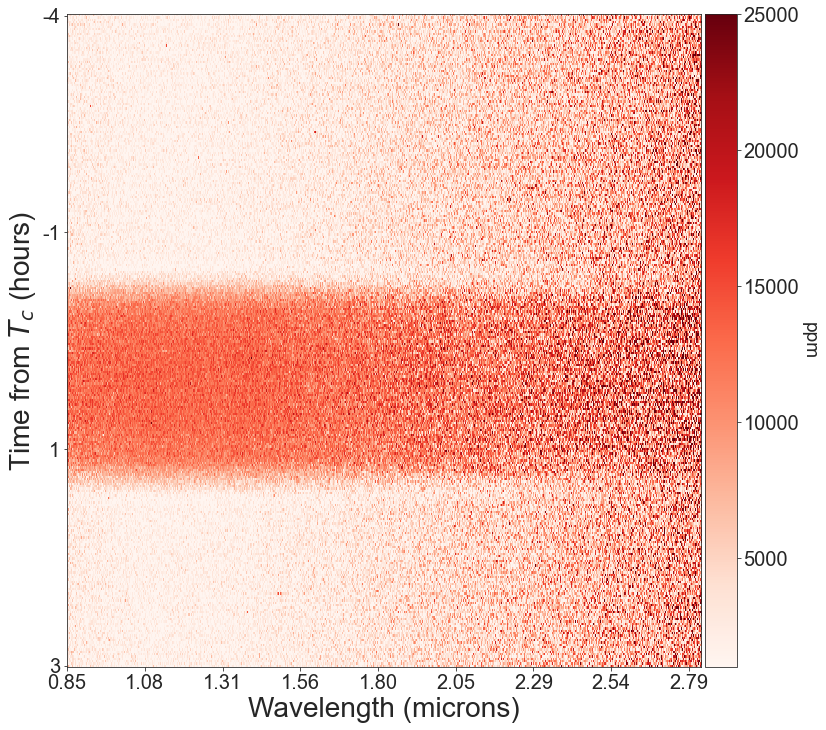

<Figure size 1296x252 with 0 Axes>

In [73]:
fig, ax1 = plt.subplots(figsize=(12, 12))

# First, order 1:
#plt.title('Order 1 lightcurves', fontsize = 50)
plt.xlabel('Wavelength (microns)', fontsize = 28)
plt.ylabel('Time from $T_c$ (hours)', fontsize = 28)
im1 = ax1.imshow(np.abs(matrices['order1'].T), interpolation='none', cmap='Reds', aspect = 'auto')
im1.set_clim(1000,25000)

# X axis:
ticks = np.arange(0, len(matrices['order1 wavelengths']), 250)
ticklabels = ["{:0.2f}".format(matrices['order1 wavelengths'][i]) for i in ticks]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticklabels, fontsize=20)

# Y axis:
ticks = np.arange(0, len(t),93)
ticklabels = ["{:0.0f}".format(times_hours[i]) for i in ticks]
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabels, fontsize=20)

# Colorbar:
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im1, shrink = 0.08, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('ppm', rotation=270, fontsize = 19)

plt.figure(figsize=(18,3.5))

<Figure size 1296x252 with 0 Axes>

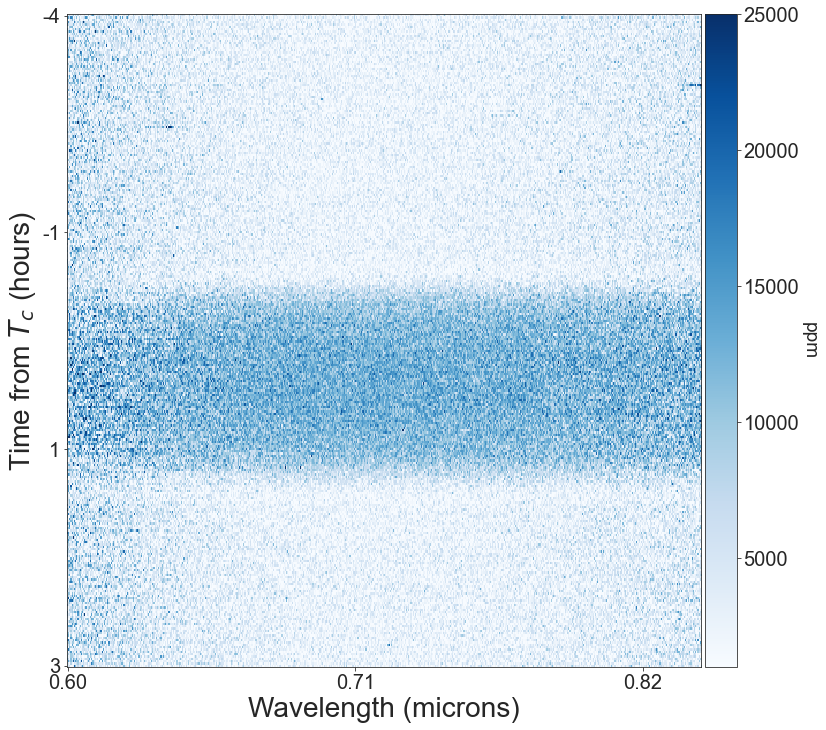

<Figure size 1296x252 with 0 Axes>

In [74]:
fig, ax1 = plt.subplots(figsize=(12, 12))

# First, order 1:
#plt.title('Order 1 lightcurves', fontsize = 50)
plt.xlabel('Wavelength (microns)', fontsize = 28)
plt.ylabel('Time from $T_c$ (hours)', fontsize = 28)
im1 = ax1.imshow(np.abs(matrices['order2'].T), interpolation='none', cmap='Blues', aspect = 'auto')
im1.set_clim(1000,25000)

# X axis:
ticks = np.arange(0, len(matrices['order2 wavelengths']), 250)
ticklabels = ["{:0.2f}".format(matrices['order2 wavelengths'][i]) for i in ticks]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticklabels, fontsize=20)

# Y axis:
ticks = np.arange(0, len(t),93)
ticklabels = ["{:0.0f}".format(times_hours[i]) for i in ticks]
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabels, fontsize=20)

# Colorbar:
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = fig.colorbar(im1, shrink = 0.08, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('ppm', rotation=270, fontsize = 19)

plt.figure(figsize=(18,3.5))

White-light lightcurve:

In [75]:
t_integrations = np.arange(len(times))
idx_oot = np.where((t_integrations<100)|(t_integrations>250))

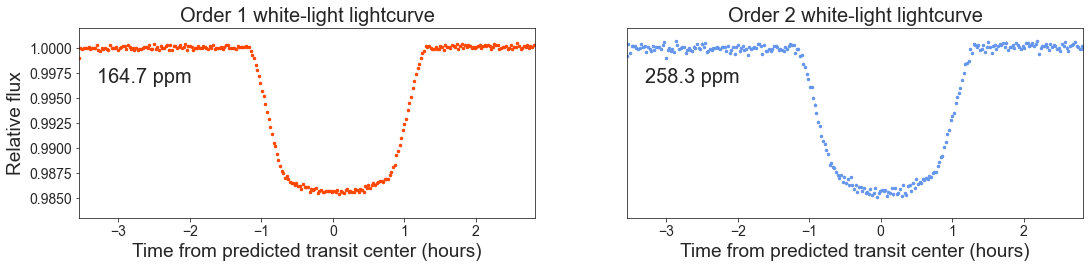

In [76]:
plt.figure(figsize=(18,3.5))

wl = {}
counter = 1
for order,color in [('order1','orangered'),('order2','cornflowerblue')]:

    plt.subplot(int('12'+str(counter)))

    flux, flux_err = lcs[order+' white light']['flux'], lcs[order+' white light']['errors']
    # idx = np.where((~np.isnan(flux)) & (flux>0))[0]

    flux, flux_err = flux / np.nanmedian( flux[idx_oot] ), flux_err / np.nanmedian( flux[idx_oot] )

    plt.errorbar(times_hours, flux, flux_err, fmt = '.', color = color, ms = 5, elinewidth = 1, label = order)
    
    wl[order] = {}
    wl[order]['times'], wl[order]['f'], wl[order]['ferr'] = t, flux, flux_err
    

    # Plotting details
    plt.xlim(np.min(times_hours), np.max(times_hours))

    plt.ylim(0.983,1.002)

    plt.xticks(fontsize=14)

    if counter == 2:
        plt.yticks([], fontsize=14)
    else:
        plt.yticks(fontsize=14)


    rms = ts.utils.get_mad_sigma(np.median(flux[idx_oot] - 1.), flux[idx_oot] - 1.)  * 1e6
    rms_predicted = np.median( flux_err[idx_oot] ) * 1e6
    plt.text(-3.3, 0.9965, '{0:.1f} ppm'.format(rms), fontsize = 20)
    plt.title('O'+order[1:-1]+' '+order[-1]+' white-light lightcurve', fontsize = 20)
    plt.xlabel('Time from predicted transit center (hours)', fontsize = 19)
    if counter == 1:
        plt.ylabel('Relative flux', fontsize = 19)

    counter += 1

Close-up out-of-transit:

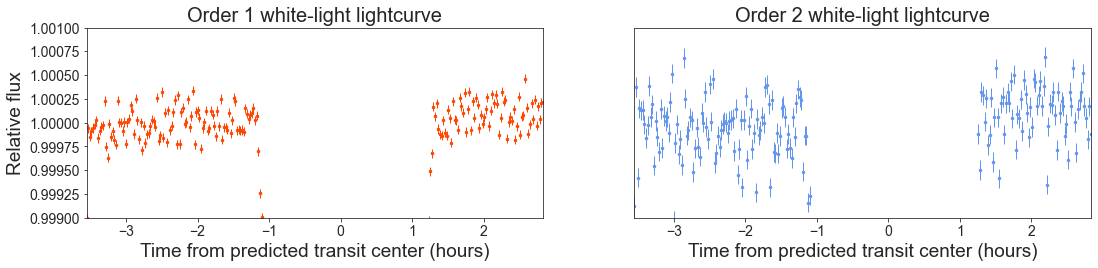

In [77]:
plt.figure(figsize=(18,3.5))

wl = {}
counter = 1
for order,color in [('order1','orangered'),('order2','cornflowerblue')]:

    plt.subplot(int('12'+str(counter)))

    flux, flux_err = lcs[order+' white light']['flux'], lcs[order+' white light']['errors']
    # idx = np.where((~np.isnan(flux)) & (flux>0))[0]

    flux, flux_err = flux / np.nanmedian( flux[idx_oot] ), flux_err / np.nanmedian( flux[idx_oot] )

    plt.errorbar(times_hours, flux, flux_err, fmt = '.', color = color, ms = 5, elinewidth = 1, label = order)
    
    wl[order] = {}
    wl[order]['times'], wl[order]['f'], wl[order]['ferr'] = t, flux, flux_err
    

    # Plotting details
    plt.xlim(np.min(times_hours), np.max(times_hours))

    plt.ylim(1-0.001,1+0.001)

    plt.xticks(fontsize=14)

    if counter == 2:
        plt.yticks([], fontsize=14)
    else:
        plt.yticks(fontsize=14)


    rms = ts.utils.get_mad_sigma(np.median(flux[idx_oot] - 1.), flux[idx_oot] - 1.)  * 1e6
    rms_predicted = np.median( flux_err[idx_oot] ) * 1e6
    #plt.text(-4.5, 0.995, '{0:.1f} ppm'.format(rms), fontsize = 20)
    plt.title('O'+order[1:-1]+' '+order[-1]+' white-light lightcurve', fontsize = 20)
    plt.xlabel('Time from predicted transit center (hours)', fontsize = 19)
    if counter == 1:
        plt.ylabel('Relative flux', fontsize = 19)

    counter += 1

Pretty stable! Quite remarkable. The errorbars are much smaller than the scatter in the actual data expected from Poisson + uncorrelated read noise. Part of that extra scatter might be 1/f noise, but part of that might also be instrumental systematics: let's try to find some more regressors that might give us some clues on what those instrumental systematics might be!

### 3.2 Searching for regressors

The first suspect for regressors is the FWHM. SOSS' cross-dispersion profile is very special as it has a sort-of-a-weak-lens that spreads the light in that direction. Let's measure it as a function of wavelength and time. Below is a custom function from the `transitspectroscopy` package that gets you the FWHM following the trace both as a function of time and the median FWHM (what we call the "super" FWHM):

In [78]:
# The trace_fwhm function returns two arrays; one (fwhms1) that gives the 
fwhms1, super_fwhm1 = ts.spectroscopy.trace_fwhm(tso, x1, y1)

In [79]:
fwhms2, super_fwhm2 = ts.spectroscopy.trace_fwhm(tso, x2, y2)

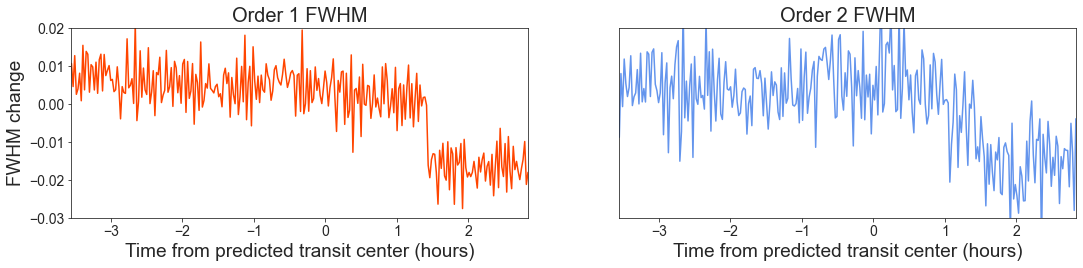

In [80]:
plt.figure(figsize=(18,3.5))

wl_fwhms = {}
wl_fwhms['order1'] = super_fwhm1
wl_fwhms['order2'] = super_fwhm2

counter = 1
for order,color in [('order1','orangered'),('order2','cornflowerblue')]:

    plt.subplot(int('12'+str(counter)))

    plt.plot(times_hours, wl_fwhms[order], color = color, label = order)

    # Plotting details
    plt.xlim(np.min(times_hours), np.max(times_hours))

    plt.xticks(fontsize=14)

    if counter == 2:
        plt.yticks([], fontsize=14)
    else:
        plt.yticks(fontsize=14)
        
    plt.ylim(-0.03,0.02)

    plt.title('O'+order[1:-1]+' '+order[-1]+' FWHM', fontsize = 20)
    plt.xlabel('Time from predicted transit center (hours)', fontsize = 19)
    if counter == 1:
        plt.ylabel('FWHM change', fontsize = 19)

    counter += 1

Woah, interesting! The FWHM actually varies quite a lot, but there is one point at about 1.5 hours in which it abruptly changes: that's most likely a ["tilt" event](https://outerspace.stsci.edu/display/JTEWG/Tilt+events+in+TSOs+tracker)! Could this explain any part of the scatter in the data? Let's see these plots side by side (grey is FWHM):

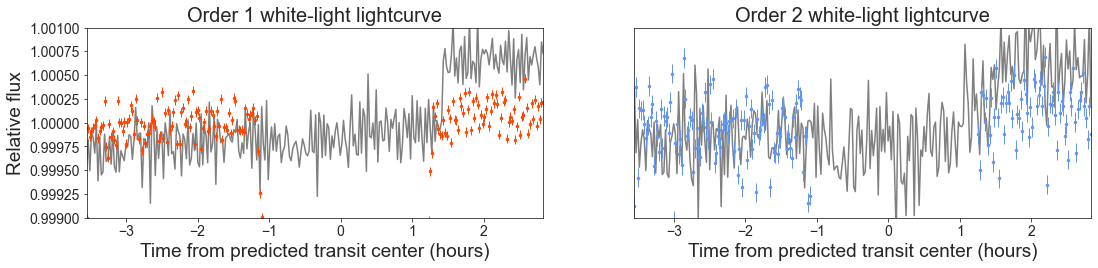

In [81]:
plt.figure(figsize=(18,3.5))

wl = {}
counter = 1
for order,color in [('order1','orangered'),('order2','cornflowerblue')]:

    plt.subplot(int('12'+str(counter)))

    
    plt.plot(times_hours, -wl_fwhms[order] * 0.04 + 1., color = 'grey', label = order)
    
    flux, flux_err = lcs[order+' white light']['flux'], lcs[order+' white light']['errors']
    # idx = np.where((~np.isnan(flux)) & (flux>0))[0]

    flux, flux_err = flux / np.nanmedian( flux[idx_oot] ), flux_err / np.nanmedian( flux[idx_oot] )

    plt.errorbar(times_hours, flux, flux_err, fmt = '.', color = color, ms = 5, elinewidth = 1, label = order)
    
    wl[order] = {}
    wl[order]['times'], wl[order]['f'], wl[order]['ferr'] = t, flux, flux_err
    

    # Plotting details
    plt.xlim(np.min(times_hours), np.max(times_hours))

    plt.ylim(1-0.001,1+0.001)

    plt.xticks(fontsize=14)

    if counter == 2:
        plt.yticks([], fontsize=14)
    else:
        plt.yticks(fontsize=14)


    rms = ts.utils.get_mad_sigma(np.median(flux[idx_oot] - 1.), flux[idx_oot] - 1.)  * 1e6
    rms_predicted = np.median( flux_err[idx_oot] ) * 1e6
    #plt.text(-4.5, 0.995, '{0:.1f} ppm'.format(rms), fontsize = 20)
    plt.title('O'+order[1:-1]+' '+order[-1]+' white-light lightcurve', fontsize = 20)
    plt.xlabel('Time from predicted transit center (hours)', fontsize = 19)
    if counter == 1:
        plt.ylabel('Relative flux', fontsize = 19)

    counter += 1

Doesn't seem like it really --- but we can check by fitting the data later with this as a regressor. There are many other variables we could track (centroid motions, for instance, trace rotation, etc.) but we don't cover that here in the interest of time. Left as an excercise to the reader!

## 3.3 Looking at wavelength-dependent lightcurves

Let's look at a handful of wavelength-dependant lightcurves:

Text(0, 0.5, 'Relative flux + offset')

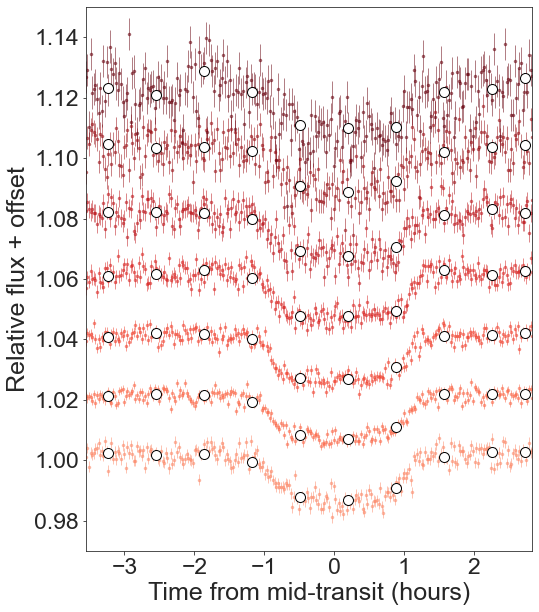

In [82]:
plt.figure(figsize = (8,10))
delta = 0.02

counter = 0

pixels = [0.851826263252849,
          1.2046122921163056,
          1.409253295937408,
          1.6051478358481832,
          1.850487238906237,
          2.1002466503233057, 
          2.400461499033153]

colormap = plt.get_cmap('Reds')

color = [colormap(k) for k in np.linspace(0.4, 1.0, len(pixels))]

for i,c in zip(pixels, color):

    lc, lcerr = lcs['order1'][i]['flux'], lcs['order1'][i]['errors']
    rel_lc = lc / np.median(lc)
    rel_lc_err = lcerr / np.median(lc)

    xbin, ybin, ybinerr = juliet.utils.bin_data(times_hours,  rel_lc, 30)

    plt.errorbar(times_hours, rel_lc + counter * delta, rel_lc_err, fmt = '.', \
                 alpha = 0.5, zorder = 1, elinewidth = 1, color = c)

    plt.errorbar(xbin, ybin + counter * delta, ybinerr, fmt = 'o', ms = 10, mfc = 'white', mec = 'black', ecolor = 'black',
                 elinewidth = 2, zorder = 4)

    counter += 1

plt.xlim(np.min(times_hours), np.max(times_hours))
plt.ylim(0.97, 1.15)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.xlabel('Time from mid-transit (hours)', fontsize = 25)
plt.ylabel('Relative flux + offset', fontsize = 25)

Text(0, 0.5, 'Relative flux + offset')

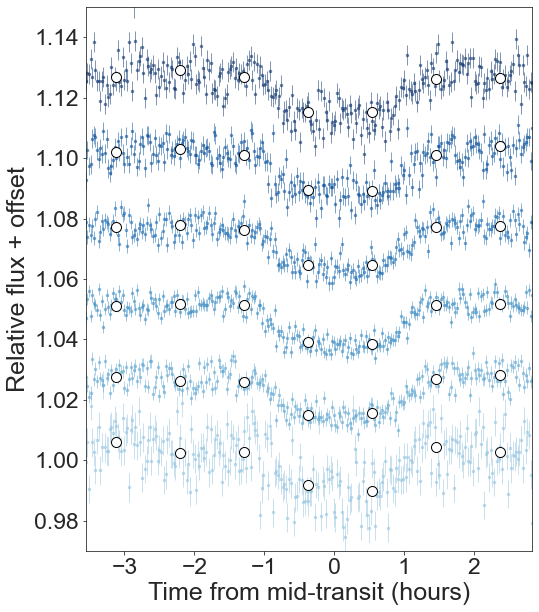

In [83]:
plt.figure(figsize = (8,10))
delta = 0.025

counter = 0

pixels = [0.6033095046373803, 
          0.6727569280605509, 
          0.7319645489257725, 
          0.7819995466168165, 
          0.8311994568673701,
          0.8428133996500791]

colormap = plt.get_cmap('Blues')

color = [colormap(k) for k in np.linspace(0.4, 1.0, len(pixels))]

for i,c in zip(pixels, color):
    
    lc, lcerr = lcs['order2'][i]['flux'], lcs['order2'][i]['errors']
    rel_lc = lc / np.median(lc) 
    rel_lc_err = lcerr / np.median(lc)
    
    idx = np.where(rel_lc >0.97)[0]
    rel_lc = rel_lc[idx]
    rel_lc_err = rel_lc_err[idx]
    
    xbin, ybin, ybinerr = juliet.utils.bin_data(times_hours[idx],  rel_lc, 40)
    
    plt.errorbar(times_hours[idx], rel_lc + counter * delta, rel_lc_err, fmt = '.', \
                 alpha = 0.5, zorder = 1, elinewidth = 1, color = c)
    
    plt.errorbar(xbin, ybin + counter * delta, ybinerr, fmt = 'o', ms = 10, mfc = 'white', mec = 'black', ecolor = 'black', 
                 elinewidth = 2, zorder = 4)

    counter += 1
    
plt.xlim(np.min(times_hours), np.max(times_hours))
plt.ylim(0.97, 1.15)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.xlabel('Time from mid-transit (hours)', fontsize = 25)
plt.ylabel('Relative flux + offset', fontsize = 25)

Pretty! Let's jump to white-light lightcurve transit fitting.

### 3.4 White-light lightcurve fitting

Let's set some priors:

In [88]:
# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'a_p1', 'b_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1',
          'p_p1_SOSS', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS', 'GP_sigma_SOSS', \
          'GP_malpha0_SOSS', 'GP_malpha1_SOSS']

# Distributions:
dists = ['fixed', 'normal', 'normal', 'truncatednormal', 'uniform', 'uniform', 'fixed', 'fixed',
         'uniform', 'fixed', 'normal', 'loguniform', 'loguniform', \
         'exponential', 'exponential']

# Hyperparameters:
hyperps = [period, [transit_center,0.2], [8.84, 0.5], [0.749, 0.1, 0., 1.], [0., 1.], [0.,1.], 0., 90.0,
           [0., 0.2], 1.0, [0., 0.1], [10., 1000.], [10., 1000.], \
           [1.], [1.]]

priors = juliet.generate_priors(params, dists, hyperps)

Set GP regressors (plus, standarize them):

In [89]:
def standarize_regressors(x):
    
    new_x = (x - np.mean(x)) / np.sqrt(np.var(x))
    
    return new_x

In [90]:
gp_regressors = {}
gp_regressors['SOSS'] = np.zeros([len(t), 2])
gp_regressors['SOSS'][:, 0] = standarize_regressors(t)

In [91]:
wl_results = {}
for order in ['order1', 'order2']:
    
    print('Fitting ',order)
    times, fluxes, fluxes_error = {}, {}, {}
    
    times['SOSS'], fluxes['SOSS'], fluxes_error['SOSS'] = wl[order]['times'], \
                                                          wl[order]['f'], \
                                                          wl[order]['ferr']
    
    # GP regressor:
    gp_regressors['SOSS'][:, 1] = standarize_regressors(wl_fwhms[order])
    
    # Perform juliet fits:
    wl_results[order] = {}
    wl_results[order]['dataset'] = juliet.load(priors=priors, t_lc=times, y_lc=fluxes, \
                                               yerr_lc=fluxes_error, GP_regressors_lc = gp_regressors,\
                                               out_folder=order+'_'+'GP-fwhm-white-light-square-root', \
                                               ld_laws = 'squareroot', george_hodlr = False)
        
    wl_results[order]['result'] = wl_results[order]['dataset'].fit(sampler = 'dynamic_dynesty', \
                                                                   bound = 'single', nthreads=8)

Fitting  order1


21372it [43:48, 14.54it/s, batch: 0 | bound: 262 | nc: 31 | ncall: 625229 | eff(%):  3.416 | loglstar:   -inf < 2068.464 <    inf | logz: 2030.011 +/-  0.264 | dlogz:  0.048 >  0.010]   Traceback (most recent call last):
  File "/Users/japa6985/opt/anaconda3/envs/jwst_tra/lib/python3.9/site-packages/dynesty-1.2.3-py3.9.egg/dynesty/dynesty.py", line 1029, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/Users/japa6985/opt/anaconda3/envs/jwst_tra/lib/python3.9/site-packages/juliet-2.2.2-py3.9.egg/juliet/fit.py", line 1354, in loglike
    log_likelihood += self.lc.get_log_likelihood(self.posteriors)
  File "/Users/japa6985/opt/anaconda3/envs/jwst_tra/lib/python3.9/site-packages/juliet-2.2.2-py3.9.egg/juliet/fit.py", line 3450, in get_log_likelihood
    self.dictionary[instrument][
  File "/Users/japa6985/opt/anaconda3/envs/jwst_tra/lib/python3.9/site-packages/juliet-2.2.2-py3.9.egg/juliet/fit.py", line 4094, in set_parameter_vector
    self.GP.set

Exception while calling loglikelihood function:
  params: [2.45975182e+06 9.05637319e+00 7.22559154e-01 2.23046566e-01
 1.75039239e-01 1.19612702e-01 1.28324159e-05 1.39265773e+02
 7.85623079e+01 1.01187380e+00 2.51724349e-01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
transit_center = np.median(wl_results[order]['result'].posteriors['posterior_samples']['t0_p1'])

for order,color in [('order1','orangered'),('order2','cornflowerblue')]:
    
    plt.figure(figsize=(10,4))
    
    
    normalized_time = (wl[order]['times'] - transit_center) * 24
    
    sigma_SOSS = np.median(wl_results[order]['result'].posteriors['posterior_samples']['sigma_w_SOSS']*1e-6)
    
    total_errors = np.sqrt(sigma_SOSS**2 + wl_results[order]['dataset'].errors_lc['SOSS']**2)
    
    plt.errorbar(normalized_time, \
                 wl_results[order]['dataset'].data_lc['SOSS'], \
                 yerr = total_errors, \
                 fmt = '.', color = color, ms = 4, elinewidth = 1, zorder = 1)
    
    # Evaluate model:
    transit_model, transit_up68, transit_low68  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True)
    
    transit_model, transit_up99, transit_low99  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True, alpha = 0.99)
        
    plt.plot(normalized_time, transit_model, color = 'black', lw=3, zorder=2)
        
    plt.fill_between(normalized_time, transit_up68, transit_low68, \
                     color=color,alpha=0.5, zorder=3)
    
    plt.fill_between(normalized_time, transit_up99, transit_low99, \
                     color=color,alpha=0.5, zorder=3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(np.min(normalized_time), np.max(normalized_time))
    plt.xlabel('Time from mid-transit (hours)', fontsize = 19)
    plt.ylabel('Relative flux', fontsize = 19)

In [ ]:
transit_center = np.median(wl_results[order]['result'].posteriors['posterior_samples']['t0_p1'])

for order,color in [('order1','orangered'),('order2','cornflowerblue')]:
    
    plt.figure(figsize=(10,4))
    
    
    normalized_time = (wl[order]['times'] - transit_center) * 24
    
    sigma_SOSS = np.median(wl_results[order]['result'].posteriors['posterior_samples']['sigma_w_SOSS']*1e-6)
    
    total_errors = np.sqrt(sigma_SOSS**2 + wl_results[order]['dataset'].errors_lc['SOSS']**2)
    
    plt.errorbar(normalized_time, \
                 wl_results[order]['dataset'].data_lc['SOSS'], \
                 yerr = total_errors, \
                 fmt = '.', color = color, ms = 4, elinewidth = 1, zorder = 1)
    
    # Evaluate model:
    transit_model, transit_up68, transit_low68  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True)
    
    transit_model, transit_up99, transit_low99  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True, alpha = 0.99)
        
    plt.plot(normalized_time, transit_model, color = 'black', lw=3, zorder=2)
        
    plt.fill_between(normalized_time, transit_up68, transit_low68, \
                     color=color,alpha=0.5, zorder=3)
    
    plt.fill_between(normalized_time, transit_up99, transit_low99, \
                     color=color,alpha=0.5, zorder=3)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(np.min(normalized_time), np.max(normalized_time))
    plt.xlabel('Time from mid-transit (hours)', fontsize = 19)
    plt.ylabel('Relative flux', fontsize = 19)
    plt.ylim(1-0.001,1+0.001)

In [ ]:
transit_center = np.median(wl_results[order]['result'].posteriors['posterior_samples']['t0_p1'])
residuals = {}
residuals_errors = {}

for order,color in [('order1','orangered'),('order2','cornflowerblue')]:
    
    plt.figure(figsize=(10,4))
    
    normalized_time = (wl[order]['times'] - transit_center) * 24
    
    # Evaluate model:
    transit_model, transit_up68, transit_low68  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True)
    
    transit_model, transit_up99, transit_low99  = \
                   wl_results[order]['result'].lc.evaluate('SOSS', return_err=True, alpha = 0.99)
    
    sigma_SOSS = np.median(wl_results[order]['result'].posteriors['posterior_samples']['sigma_w_SOSS'])*1e-6
        
    plt.errorbar(normalized_time, \
                 (wl_results[order]['dataset'].data_lc['SOSS'] - transit_model)*1e6, \
                 yerr = np.sqrt(wl_results[order]['dataset'].errors_lc['SOSS']**2 + sigma_SOSS**2)*1e6, \
                 fmt = '.', color = color, ms = 4, elinewidth = 1, zorder = 1)
    
    residuals[order] = (wl_results[order]['dataset'].data_lc['SOSS'] - transit_model)*1e6
    residuals_errors[order] = np.sqrt(wl_results[order]['dataset'].errors_lc['SOSS']**2 + sigma_SOSS**2)*1e6
    
    plt.plot([-5,5],[0,0], '--', color = 'black')
    
    print(ts.utils.get_mad_sigma(np.nanmedian((wl_results[order]['dataset'].data_lc['SOSS'] - transit_model)*1e6), \
                                 (wl_results[order]['dataset'].data_lc['SOSS'] - transit_model)*1e6), 'ppm precision for',order)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(-1000,1000)
    plt.xlim(np.min(normalized_time), np.max(normalized_time))
    #plt.title('White-lightcurves --- '+order+' residuals', fontsize = 20)
    plt.xlabel('Time from mid-transit (hours)', fontsize = 19)
    plt.ylabel('Residuals (ppm)', fontsize = 19)

Some Allan variance plots:

In [ ]:
def bin_data(x, y, n_bin):
    
    x_bins = []
    y_bins = []
    y_err_bins = []
    
    for i in range(0,len(x),n_bin):
        
        x_bins.append(np.median(x[i:i+n_bin-1]))
        y_bins.append(np.median(y[i:i+n_bin-1]))
        y_err_bins.append(np.sqrt(np.var(y[i:i+n_bin-1]))/np.sqrt(len(y[i:i+n_bin-1])))
        
    return np.array(x_bins), np.array(y_bins), np.array(y_err_bins)

In [ ]:
nbins = np.arange(2,310,1)
scatter = np.zeros(len(nbins))
order = 'order1'

for i in range(len(nbins)):
    
    xbin, ybin, ybinerr = bin_data(normalized_time,  residuals[order], nbins[i])
    scatter[i] = np.sqrt(np.var(ybin))

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(nbins, scatter, 'o-', color = 'black')
plt.plot(nbins, (np.sqrt(nbins[0]) * scatter[0]*0.8) / np.sqrt(nbins), '--', \
         color = 'orangered', lw = 3)
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMS (ppm)', fontsize = 25)
plt.xlabel('Bin size', fontsize = 25)
plt.xticks([2, 10, 20, 30, 50, 100, 300], ['2', '10', '20', '30', '50', '100', '300'], fontsize=23)
plt.yticks([10, 20, 30, 50, 100, 200], ['10', '20', '30', '50', '100', '200'], fontsize=23)
plt.yticks(fontsize=23)
plt.xlim(np.min(nbins),np.max(nbins))
plt.ylim(1, 200)

In [ ]:
nbins = np.arange(2,310,1)
scatter = np.zeros(len(nbins))
order = 'order2'

for i in range(len(nbins)):
    
    xbin, ybin, ybinerr = bin_data(normalized_time,  residuals[order], nbins[i])
    scatter[i] = np.sqrt(np.var(ybin))

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(nbins, scatter, 'o-', color = 'black')
plt.plot(nbins, (np.sqrt(nbins[0]) * scatter[0]*0.8) / np.sqrt(nbins), '--', \
         color = 'cornflowerblue', lw = 3)
#plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel('RMS (ppm)', fontsize = 25)
plt.xlabel('Bin size', fontsize = 25)
plt.xticks([2, 10, 20, 30, 50, 100, 300], ['2', '10', '20', '30', '50', '100', '300'], fontsize=23)
plt.yticks([10, 20, 30, 50, 100, 200], ['10', '20', '30', '50', '100', '200'], fontsize=23)
plt.yticks(fontsize=23)
plt.xlim(np.min(nbins),np.max(nbins))
plt.ylim(1, 300)

In [ ]:
for order in ['order1', 'order2']:
    
    print('\nResults for ' + order + ':')
    print('----------------')
    
    for parameters in ['t0_p1', 'p_p1', 'a_p1', 'b_p1', 'sigma_w_SOSS', 'q1_SOSS', 'q2_SOSS']:
        
        posteriors = wl_results[order]['result'].posteriors['posterior_samples'][parameters]
        med, valup, valdown = juliet.utils.get_quantiles(posteriors)
        print('\t '+parameters + ':', med, '+', valup-med, '-', med - valdown)
        if parameters == 'p_p1':
            med, valup, valdown = juliet.utils.get_quantiles((posteriors**2)*1e6)
            print('\t transit depth:', med, '+', valup-med, '-', med - valdown)

These look good! Not absolutely perfect, perhaps, but good for a quick-look analysis. You can now take these results and use them to fit wavelength-dependant lightcurves on your own!